<a href="https://colab.research.google.com/github/vin-nag/crypto_boost/blob/master/presentation_cv_oil_spill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Holenstein Boosting Algorithm
### Based on Dr. Russell Impagliazzo's paper

In [0]:
# imports

# generics
%matplotlib inline
import math
import operator
import numpy as np
from numpy.random import choice
from matplotlib import pyplot as plt
import pandas as pd
import timeit
from tqdm.auto import tqdm
from numba import jit, njit

# ml related
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import fetch_openml

In [0]:
# Aggregating weak learners using simple holenstein boosting algorithm

class HolensteinBoostClassifier:
    
    def __init__(self):
        """
        Standard Init function
        :return: none 
        """ 
        self.weak_learners = []
        self.threshold = 0
        HolensteinBoostClassifier.map_to_interval = np.vectorize(HolensteinBoostClassifier.map_to_interval)
        
    @staticmethod
    @jit(parallel=True)
    def train_weak_learner(X, y, weights, probabilities, indices):
        """
        This function performs one iteration of weak learner training, as described in the dense model paper
        :param X: nd-array of size m*n training data
        :param y: 1d-array of size n labels
        :param weights: 1d-array of size n weights corresponding to weight of each instance
        :param probabilities: 1d-array of size n corresponding to probabilities for each instance
        :param indices: 1d-array of size n corresponding to indices of each array
        :return: weak learner, indices of instances used to fit 
        """ 
        
        # get indices of selected samples to train
        selected_indices = HolensteinBoostClassifier.use_rejection_sample(indices, probabilities, weights)

        # select data based on indices
        X_selected = X[selected_indices,:]
        y_selected = y[selected_indices]

        # train the weak learner
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X_selected, y_selected)

        return stump

    @staticmethod
    @jit(parallel=True)
    def find_density(elements):
        """
        This function calculates the density of a set, assuming the set has a uniform probability distribution.
        :param elements: 1d-array 
        :return: float density of the set
        """
        return np.sum(elements)

    @staticmethod
    @jit(parallel=True)
    def use_rejection_sample(elements, probabilities, weights, size=None, replacement=True):
        """
        This function performs rejection sampling, selecting an element based on its probability,
        and accepting it based on its weight
        :param elements: 1d-array elements to choose
        :param probabilities: 1d-array, same size as elements array
        :param weights: 1d-array, same size as elements array
        :param size: int, size of array. if None, size defaults to number of elements//10
        :param replacement: boolean, whether to allow for replacement in set. default=False
        :return: 1d-array of length size """
        
        if size is None:
            size=len(elements)//10
        
        choices = []
        
        while len(choices) < size:
            new_choice = choice(elements, p=probabilities)
            if np.random.rand() <= weights[new_choice]:    
                if replacement:
                    choices.append(new_choice)
                else:
                    if new_choice not in choices:
                        choices.append(new_choice)        

        return choices
    
    def reset(self):
        """
        This function resets class variables
        :return: none 
        """ 
        self.weak_learners = []
        self.threshold = 0
        return
    
    @staticmethod
    @jit(parallel=True)
    def update_sums(predictions, sums, y):
        """
        This function updates the weight of each instance based on the performance of all the weak learners on
        :param predictions: 1d-array of predictions by a weak learner
        :param sums: 1d-array of current sums of all instances
        :param y: 1d-array of true labels of values in [1,-1]       
        :return: 1d-array of sums
        """
        results = np.multiply(predictions, y)
        sums = np.add(results, sums)
        return sums

    @jit(parallel=True)
    def update_weights(self, sums, weights, indices, s):
        """
        This function updates the weight of each instance based on the performance of all the weak learners on
        :param weak_learners: 1d-array of trained weak learners that can predict
        :param X: nd-array of size m*n training data
        :param y: 1d-array of size n training labels
        :param weights: 1d-array of size n weights for each instance
        :param indices: 1d-array of size c<=n indices of instances to predict
        :param s: int value used to artificially increase density of set
        :return: 1d-array of weights
        """
        
        for index in indices:
            weights[index] = self.map_to_interval(sums[index]-s)
        return weights
    
    @staticmethod
    @njit
    def map_to_interval(num, epsilon=0.01):
        """
        This function maps an Integer to the interval [0,1], using the properties described in
        dense model paper M[num] = min(1, e^(-epsilon*num))
        :param num: int value to map
        :param epsilon: float scaling factor
        :return: float mapped version of num
        """
        return min(1.0, math.exp(-1*epsilon*num))        
    
    def fit(self, X, y, delta=0.05, epsilon=0.01, n_estimators=100):
        """
        This function fits the boosting model to the training data, and hyperparameter tunes the model
        :param X: nd-array of training instances
        :param y: 1d-array of labels
        :param delta: parameter referring to the hard-core size of the set, or alternatively, the accuracy
        :param epsilon: parameter representing indistinguishability of distributions
        :param n_estimators: int representing the number of weak learners to train. default of 100
        :return: none
        """
        # reset class level variables
        self.reset()
        
        # declare variables
        counter = 0
        s = 0
        delta = delta
        epsilon = epsilon
        c = 0.002

        weights = [1/len(X) for elem in X]
        probabilities = [1/len(X) for elem in X]
        indices = np.arange(len(X))
        sums = [0 for elem in X]
        
        # repeat C=n_estimator times
        while counter < n_estimators:
            
            # train next weak learner
            learner = HolensteinBoostClassifier.train_weak_learner(X, y, weights, probabilities, indices)
            
            # get predictions of trained weak learner
            predictions = HolensteinBoostClassifier.predict_each_learner(learner, X)
            
            # update sums of all instances based on predictions
            sums = HolensteinBoostClassifier.update_sums(predictions, sums, y)
            
            # update weights of all instances based on sum
            weights = self.update_weights(sums, weights, indices, s)

            # add weak learner to ensemble
            self.weak_learners.append(learner)
            
            # artificially increase density if smaller than hard-core size
            if HolensteinBoostClassifier.find_density(weights) < 2*delta:
                s += 1    
                
            # increment counter
            counter += 1
                 
        # hyper parameter tune the model
        self.hyperParameterTuning(X, y, n_estimators, sums)

        return
    
    @jit(parallel=True)
    def hyperParameterTuning(self, X, y, n_estimators, sums=None):
      """
      This function tunes the hyperparameters
      :param X: nd-array of instances
      :param y: 1d-array of labels
      :param n_estimators: number of weak learners
      :param sums: the sums of all predictions
      :return none
      """
      # calculate sums if not given
      if sums is None:      
        sums = self.sumAllPredictions(X)
      
      # declare variables
      best_threshold, best_accuracy = 0, 0

      # loop though all possible threshold
      for threshold in range(-n_estimators, n_estimators+1):
        
        # get current threshold accuracy
        current_predictions = np.sign(sums-threshold)
        current_accuracy = accuracy_score(y, current_predictions)

        # check if current threshold is best so far
        if current_accuracy > best_accuracy:
          best_accuracy = current_accuracy
          best_threshold = threshold

      # set class level threshold to best threshold found
      self.threshold = best_threshold
      return
    
    @jit(parallel=True)
    def sumAllPredictions(self, X):
      """
      This function calculates the sum of all instances
      :param X: nd-array of instances
      return sums: 1d-array of sums size of length of instances
      """
      # declare variable
      sums = np.zeros(len(X))
      # loop through all weak learners
      for learner in self.weak_learners:
        # add sums for all instances
        sums = np.add(sums, learner.predict(X))
      return sums
        
    @staticmethod
    @jit(parallel=True)
    def predict_each_learner(learner, X):
        """
        This method predicts an instance, using majority vote
        :param instance: 1d-array instance to predict
        :return: int prediction
        """
        predictions = [learner.predict(x.reshape(1,-1))[0] for x in X]
        return predictions

    @jit(parallel=True)
    def predict(self, X):
        """
        This method predicts all instances, using majority vote
        :param X: 2d-array data to predict
        :return: 1d-array predictions
        """
        return np.sign(self.sumAllPredictions(X))


In [0]:
def convert_labels(x):
    """
    This function converts the 0s in the label to -1 to suit holenstein algorithm
    :param x: int label 
    :return: int -1 or 1 based on label
    """
    return int(x)

# vectorize the function to improve runtime performance
convert_labels = np.vectorize(convert_labels, otypes=[np.float])


## Main process of the algorithm

In [0]:
data = fetch_openml(name='oil_spill')

features = data.data
labels = convert_labels(data.target)

print('features shape = ', features.shape)
print('labels shape = ', labels.shape)

features shape =  (937, 49)
labels shape =  (937,)


In [0]:
NUM_ESTIMATORS = 50
FOLDS = 10

In [0]:
# Holenstein Boost
hol_start_time = timeit.default_timer()
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
holboost = HolensteinBoostClassifier()
hol_scores = []
pbar = tqdm(total=10*FOLDS)

for train_index, test_index in skf.split(features, labels):

    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    holboost.fit(X_train, y_train, n_estimators=NUM_ESTIMATORS)
    predictions = holboost.predict(X_test)
    hol_scores.append(accuracy_score(y_test, predictions))  
    pbar.update(10)

hol_elapsed = timeit.default_timer() - hol_start_time

In [0]:
# Adaboost

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
adaboost = AdaBoostClassifier(n_estimators=NUM_ESTIMATORS)
ada_params = {'learning_rate':[1,0.75]}
ada_start_time = timeit.default_timer()
ada_scores = []
pbar = tqdm(total=10*FOLDS)

for train_index, test_index in skf.split(features, labels):

    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    ada_cv = GridSearchCV(estimator=adaboost, param_grid=ada_params, cv=FOLDS, scoring='average_precision')
    ada_cv.fit(X_train, y_train)
    ada_scores.append(ada_cv.best_estimator_.score(X=X_test, y=y_test))
    
    pbar.update(10)
    
ada_elapsed = timeit.default_timer() - ada_start_time

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

In [0]:
# Gradient Descent Boost
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
gdboost = GradientBoostingClassifier(n_estimators=NUM_ESTIMATORS)
gd_params = {'max_depth':[2,3,5], 'learning_rate':[1,0.75]}
gd_start_time = timeit.default_timer()
gd_scores = []
pbar = tqdm(total=10*FOLDS)

for train_index, test_index in skf.split(features, labels):

    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    gd_cv = GridSearchCV(estimator=adaboost, param_grid=ada_params, cv=FOLDS, scoring='average_precision')
    gd_cv.fit(X_train, y_train)
    gd_scores.append(ada_cv.best_estimator_.score(X=X_test, y=y_test))
    
    pbar.update(10)

gd_elapsed = timeit.default_timer() - gd_start_time

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

[Text(0, 0, 'Holenstein Boost'),
 Text(0, 0, 'AdaBoost'),
 Text(0, 0, 'Gradient Descent Boost')]

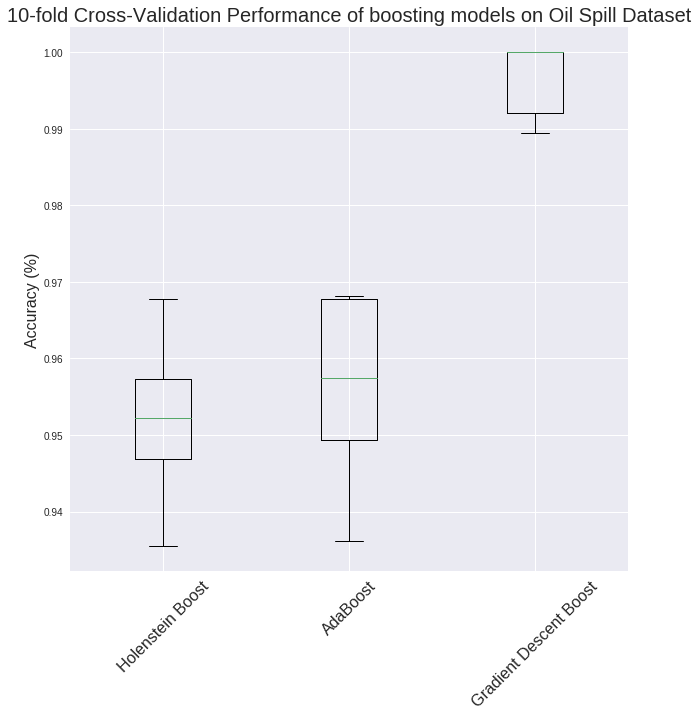

In [0]:
# combine the three scores for box-plots
all_scores = np.stack((hol_scores, ada_scores, gd_scores), axis=1)
boost_names = ['Holenstein Boost', 'AdaBoost', 'Gradient Descent Boost']

# Create box plot for the three 
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('10-fold Cross-Validation Performance of boosting models on Oil Spill Dataset', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=16)

ax.boxplot(all_scores, labels=boost_names)
ax.set_xticklabels(boost_names, rotation=45, fontsize=16)

[Text(0, 0, 'Holenstein Boost'),
 Text(0, 0, 'AdaBoost'),
 Text(0, 0, 'Gradient Descent Boost')]

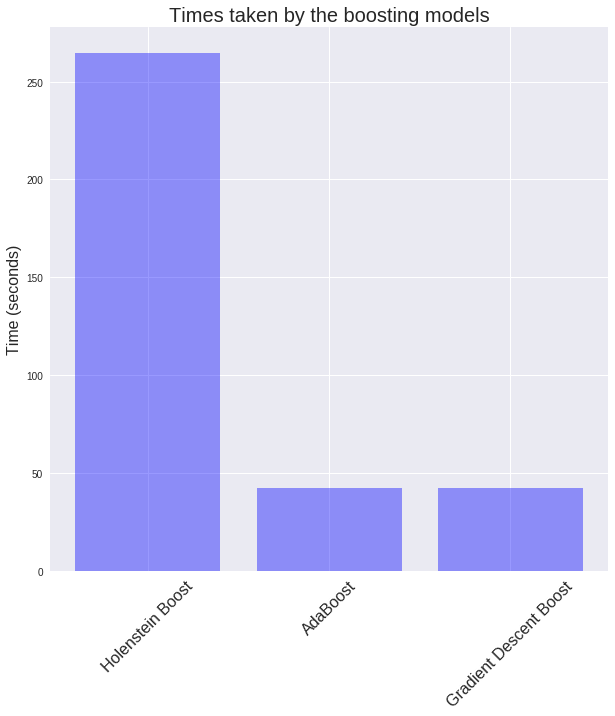

In [0]:
# plot time taken

times = np.stack((hol_elapsed, ada_elapsed, gd_elapsed), axis=0)
fig, ax = plt.subplots(figsize=(10,10))
index = np.arange(times.size)

# Create box plot for the three 
ax.set_ylabel('Time (seconds)', fontsize=16)
ax.set_title('Times taken by the boosting models', fontsize=20)

ax.bar(index, times, alpha=0.4, color='b',label='Times')

ax.set_xticks(index)
ax.set_xticklabels(boost_names, rotation=45, fontsize=16)